In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

2023-07-16 08:21:25.870694: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
drugs_cell_lines_ic50_df = pd.read_csv("..//data//drugs_cell_lines_ic50.csv")

In [3]:
drugs_cell_lines_ic50_df.head()

,drug_id,Cancer_Cell_Line,IC50
0,1001,ACH-002137,7.258918
1,1004,ACH-002137,-3.802467
2,1005,ACH-002137,4.146364
3,1006,ACH-002137,3.171367
4,1007,ACH-002137,-4.959442


In [4]:
pubchem_drugs_smiles_df = pd.read_csv('..//data//drugs_smile_strings.csv')

In [5]:
pubchem_drugs_smiles_df.head()

,drug_id,Smiles
0,1242,COc1cc(O)c2c(c1)C=CCC(O)C(O)C(=O)C=CCC(C)OC2=O
1,179,O=c1[nH]cc(F)c(=O)[nH]1
2,86,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4c[nH]c5ccccc45)...
3,55,COc1cc(-c2nn(C3CCC(N4CCN(C(C)=O)CC4)CC3)c3ncnc...
4,1001,NC(=O)c1ncn(C2OC(COP(=O)(O)O)C(O)C2O)c1N


In [6]:
drugs_smiles_cell_lines_ic50_df = pd.merge(drugs_cell_lines_ic50_df, pubchem_drugs_smiles_df, 
                                             on = "drug_id")

In [7]:
drugs_smiles_cell_lines_ic50_df = drugs_smiles_cell_lines_ic50_df[["drug_id", "Cancer_Cell_Line", "Smiles", "IC50"]]

In [8]:
drugs_smiles_cell_lines_ic50_df.dtypes

drug_id               int64
Cancer_Cell_Line     object
Smiles               object
IC50                float64
dtype: object

In [9]:
drugs_smiles_cell_lines_ic50_df["drug_id"] = drugs_smiles_cell_lines_ic50_df["drug_id"].astype(str)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(drugs_smiles_cell_lines_ic50_df.drop(["IC50"],1), drugs_smiles_cell_lines_ic50_df["IC50"].values, 
                                                     test_size = 0.10, random_state = 42)

/tmp/ipykernel_3276425/365374518.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_valid, y_train, y_valid = train_test_split(drugs_smiles_cell_lines_ic50_df.drop(["IC50"],1), drugs_smiles_cell_lines_ic50_df["IC50"].values,


In [12]:
# load models
# omic models
cancer_copy_number_model = tf.keras.models.load_model("..//Models//cancer_copy_number_model_no_norm")
cancer_cell_gen_expr_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_expr_model_no_norm")
cancer_cell_gen_methy_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_methy_model_no_norm")
cancer_cell_gen_mut_model = tf.keras.models.load_model("..//Models//cancer_cell_gen_mut_model_no_norm")

2023-07-16 08:21:28.422251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-07-16 08:21:28.928384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78910 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:98:00.0, compute capability: 8.0


In [13]:
# load models
# drug models
pubchem_drugs_rdkit_model = tf.keras.models.load_model("..//Models//pubchem_drugs_rdkit_model_no_norm")

In [14]:
# extract drug features
drug_features_train = pubchem_drugs_rdkit_model(x_train["drug_id"].values).numpy()
drug_features_valid = pubchem_drugs_rdkit_model(x_valid["drug_id"].values).numpy()

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
std = StandardScaler()

In [17]:
drug_features_train = std.fit_transform(drug_features_train)

In [18]:
drug_features_valid = std.transform(drug_features_valid)

In [19]:
drug_features_train.shape, drug_features_valid.shape

((168110, 106), (18679, 106))

In [20]:
# extract copy number features
omics_copy_number_train = cancer_copy_number_model(x_train["Cancer_Cell_Line"].values).numpy()
omics_copy_number_valid = cancer_copy_number_model(x_valid["Cancer_Cell_Line"].values).numpy()

In [21]:
omics_copy_number_train.shape, omics_copy_number_valid.shape

((168110, 710), (18679, 710))

In [22]:
# extract gen expr features
omics_gen_expr_train = cancer_cell_gen_expr_model(x_train["Cancer_Cell_Line"].values).numpy()
omics_gen_expr_valid = cancer_cell_gen_expr_model(x_valid["Cancer_Cell_Line"].values).numpy()

In [23]:
omics_gen_expr_train.shape, omics_gen_expr_valid.shape

((168110, 697), (18679, 697))

In [24]:
# extract gen methylation features
omics_gen_methyl_train = cancer_cell_gen_methy_model(x_train["Cancer_Cell_Line"].values).numpy()
omics_gen_methyl_valid = cancer_cell_gen_methy_model(x_valid["Cancer_Cell_Line"].values).numpy()

In [25]:
omics_gen_methyl_train.shape, omics_gen_methyl_valid.shape

((168110, 808), (18679, 808))

In [26]:
# extract gen mutation features
omics_gen_mut_train = cancer_cell_gen_mut_model(x_train["Cancer_Cell_Line"].values).numpy()
omics_gen_mut_valid = cancer_cell_gen_mut_model(x_valid["Cancer_Cell_Line"].values).numpy()

In [27]:
omics_gen_mut_train.shape, omics_gen_mut_valid.shape

((168110, 34673), (18679, 34673))

In [28]:
smile_strings_train = x_train["Smiles"].values.reshape(-1,1)
smile_strings_valid = x_valid["Smiles"].values.reshape(-1,1)

In [29]:
smile_strings_train.shape, smile_strings_valid.shape

((168110, 1), (18679, 1))

In [30]:
input_smiles_string = tf.keras.layers.Input(shape = (1,), dtype = tf.string)

In [31]:
text_vec = tf.keras.layers.TextVectorization(standardize=None,
    split='character', output_mode = "int")

text_vec.adapt(smile_strings_train, batch_size = 100000)

In [32]:
text_vec_output = text_vec(input_smiles_string)

In [33]:
embedding_layer = tf.keras.layers.Embedding(len(text_vec.get_vocabulary()), 128)
embedding_output = embedding_layer(text_vec_output)
lstm_layer = tf.keras.layers.LSTM(64)
lstm_output_smiles = lstm_layer(embedding_output)

In [34]:
bottleneck_layer_smiles = tf.keras.layers.Dense(32, activation = "relu")

In [35]:
bottleneck_layer_smiles_out = bottleneck_layer_smiles(lstm_output_smiles)

In [36]:
input_rdkit = tf.keras.layers.Input(shape = (drug_features_train.shape[1],))

In [37]:
input_rdkit = tf.keras.layers.BatchNormalization()(input_rdkit)

In [38]:
dense_rdkit_layer = tf.keras.layers.Dense(64, activation = "relu")

In [39]:
rdkit_embs = dense_rdkit_layer(input_rdkit)
dense_rdkit_layer = tf.keras.layers.Dense(32, activation = "relu")
rdkit_embs = dense_rdkit_layer(rdkit_embs)

In [40]:
rdkit_with_smile_embs = tf.keras.layers.Concatenate()([rdkit_embs, bottleneck_layer_smiles_out])

In [41]:
drugs_final_emb_layer = tf.keras.layers.Dense(32, activation = "relu")

In [42]:
drugs_smiles_rdkit_embs = drugs_final_emb_layer(rdkit_with_smile_embs)

In [43]:
# drugs_smiles_rdkit_embs = tf.keras.layers.Dropout(0.25)(drugs_smiles_rdkit_embs)

In [44]:
input_copy_number = tf.keras.layers.Input(shape = (omics_copy_number_train.shape[1],))

In [45]:
input_copy_number = tf.keras.layers.BatchNormalization()(input_copy_number)

In [46]:
copy_number_layer = tf.keras.layers.Dense(256, activation = "relu")

In [47]:
copy_number_emb = copy_number_layer(input_copy_number)

In [48]:
copy_number_layer = tf.keras.layers.Dense(100, activation = "relu")

In [49]:
copy_number_emb = copy_number_layer(copy_number_emb)

In [50]:
input_gen_expr = tf.keras.layers.Input(shape = (omics_gen_expr_train.shape[1],))

In [51]:
input_gen_expr = tf.keras.layers.BatchNormalization()(input_gen_expr)

In [52]:
gen_expr_layer = tf.keras.layers.Dense(256, activation = "relu")

In [53]:
gen_expr_emb = gen_expr_layer(input_gen_expr)
gen_expr_layer = tf.keras.layers.Dense(100, activation = "relu")
gen_expr_emb = gen_expr_layer(gen_expr_emb)

In [54]:
input_gen_methy = tf.keras.layers.Input(shape = (omics_gen_methyl_train.shape[1],))

In [55]:
input_gen_methy = tf.keras.layers.BatchNormalization()(input_gen_methy)

In [56]:
gen_methy_layer = tf.keras.layers.Dense(256, activation = "relu")

In [57]:
gen_methy_emb = gen_methy_layer(input_gen_methy)

In [58]:
gen_methy_layer = tf.keras.layers.Dense(100, activation = "relu")
gen_methy_emb = gen_methy_layer(gen_methy_emb)

In [59]:
input_gen_mut = tf.keras.layers.Input(shape = (omics_gen_mut_train.shape[1],))

In [60]:
input_gen_mut = tf.keras.layers.BatchNormalization()(input_gen_mut)

In [61]:
reshape_gen_mut = tf.keras.layers.Reshape((1, omics_gen_mut_train.shape[1], 1))

In [62]:
reshape_gen_mut = reshape_gen_mut(input_gen_mut)

In [63]:
gen_mut_layer = tf.keras.layers.Conv2D(50, (1, 700), strides=5, activation = "relu")

In [64]:
gen_mut_emb = gen_mut_layer(reshape_gen_mut)

In [65]:
gen_mut_emb.shape

TensorShape([None, 1, 6795, 50])

In [66]:
pool_layer = tf.keras.layers.MaxPooling2D((1,5))

In [67]:
pool_out = pool_layer(gen_mut_emb)

In [68]:
pool_out

<KerasTensor: shape=(None, 1, 1359, 50) dtype=float32 (created by layer 'max_pooling2d')>

In [69]:
gen_mut_layer = tf.keras.layers.Conv2D(30, (1, 5), strides=2, activation = "relu")

In [70]:
gen_mut_emb = gen_mut_layer(pool_out)

In [71]:
gen_mut_emb 

<KerasTensor: shape=(None, 1, 678, 30) dtype=float32 (created by layer 'conv2d_1')>

In [72]:
pool_layer = tf.keras.layers.MaxPooling2D((1,10))

In [73]:
pool_out = pool_layer(gen_mut_emb)

In [74]:
pool_out

<KerasTensor: shape=(None, 1, 67, 30) dtype=float32 (created by layer 'max_pooling2d_1')>

In [75]:
flatten_layer = tf.keras.layers.Flatten()

In [76]:
flatten_out = flatten_layer(pool_out)

In [77]:
all_omics = tf.keras.layers.Concatenate()([copy_number_emb, gen_expr_emb, gen_methy_emb, flatten_out])

In [78]:
last_omics_emb = tf.keras.layers.Dense(64, activation = "relu")

In [79]:
final_omics_emb = last_omics_emb(all_omics)

In [80]:
# final_omics_emb = tf.keras.layers.Dropout(0.25)(final_omics_emb)

In [81]:
final_drugs_omics = tf.keras.layers.Concatenate()([drugs_smiles_rdkit_embs, final_omics_emb])

In [82]:
final_emb_layer = tf.keras.layers.Dense(32, activation = "relu")

In [83]:
final_emb = final_emb_layer(final_drugs_omics)

In [84]:
final_emb = tf.keras.layers.Dropout(0.05)(final_emb)

In [85]:
final_out_layer = tf.keras.layers.Dense(1)

In [86]:
final_out = final_out_layer(final_emb)

In [87]:
simplecdr = tf.keras.models.Model([input_smiles_string, input_rdkit, input_copy_number, 
                                  input_gen_expr, input_gen_methy, input_gen_mut], final_out)

In [88]:
simplecdr.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 34673)]      0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 34673, 1)  0           ['input_11[0][0]']               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 6795, 50)  35050       ['reshape[1][0]']                
                                                                                              

In [89]:
simplecdr.compile(loss = tf.keras.losses.MeanSquaredError(), 
                    optimizer = tf.keras.optimizers.Adam(1e-3), 
                    metrics = [tf.keras.metrics.RootMeanSquaredError()])

In [90]:
history = simplecdr.fit([smile_strings_train, drug_features_train, 
                         omics_copy_number_train, omics_gen_expr_train, 
                         omics_gen_methyl_train, omics_gen_mut_train], y_train.reshape(-1,1), 
                         
          batch_size = 512, epochs = 10000, verbose = 1,
                         
          validation_data=([smile_strings_valid, drug_features_valid, 
                           omics_copy_number_valid, omics_gen_expr_valid, 
                           omics_gen_methyl_valid, omics_gen_mut_valid], y_valid.reshape(-1,1)),
                         

        callbacks = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights=True,
                                                       mode = "min"), 
         validation_batch_size = 512, shuffle = True)

Epoch 1/10000


2023-07-16 08:21:55.862919: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-16 08:21:55.990923: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/statgrads/vpiyush2/.conda/envs/tensorflow-gpu-2.9-custom/lib/python3.9/site-packages/tensorflow/python/../../../../libcublas.so.11: undefined symbol: cublasGetSmCountTarget


329/329 [==============================] - 28s 67ms/step - loss: 2.9374 - root_mean_squared_error: 1.7139 - val_loss: 1.9079 - val_root_mean_squared_error: 1.3813
Epoch 2/10000
329/329 [==============================] - 19s 59ms/step - loss: 1.9253 - root_mean_squared_error: 1.3875 - val_loss: 1.7922 - val_root_mean_squared_error: 1.3387
Epoch 3/10000
329/329 [==============================] - 19s 59ms/step - loss: 1.8576 - root_mean_squared_error: 1.3629 - val_loss: 1.7659 - val_root_mean_squared_error: 1.3289
Epoch 4/10000
329/329 [==============================] - 19s 59ms/step - loss: 1.8234 - root_mean_squared_error: 1.3503 - val_loss: 1.7382 - val_root_mean_squared_error: 1.3184
Epoch 5/10000
329/329 [==============================] - 19s 59ms/step - loss: 1.8002 - root_mean_squared_error: 1.3417 - val_loss: 1.6761 - val_root_mean_squared_error: 1.2946
Epoch 6/10000
329/329 [==============================] - 19s 59ms/step - loss: 1.7650 - root_mean_squared_error: 1.3285 - val_los

In [91]:
simplecdr.save("..//Models//simplecdr_alt_config2")

INFO:tensorflow:Assets written to: ..//Models//simplecdr_alt_config2/assets


INFO:tensorflow:Assets written to: ..//Models//simplecdr_alt_config2/assets


In [92]:
simplecdr = tf.keras.models.load_model("..//Models//simplecdr_alt_config2")

In [93]:
val_preds = simplecdr.predict([smile_strings_valid, drug_features_valid, 
                           omics_copy_number_valid, omics_gen_expr_valid, 
                           omics_gen_methyl_valid, omics_gen_mut_valid])

584/584 [==============================] - 3s 4ms/step


In [94]:
import matplotlib.pyplot as plt

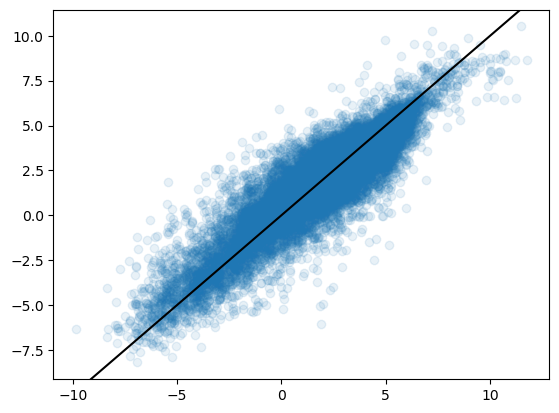

In [95]:
plt.scatter(y_valid.reshape(-1,1), val_preds, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.show()

In [96]:
from scipy.stats import pearsonr

In [97]:
res = pearsonr(y_valid.tolist(), val_preds.tolist())

In [98]:
res

(array([0.9017163023452219], dtype=object), 0.0)

In [99]:
res[0][0]

0.9017163023452219